# Paper 1: Regularization Effectiveness Study
## Autoren: Katrin Nguyen & Nico Loss

## Import & Setup

In [16]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Matplotlib inline for Jupyter Notebooks
%matplotlib inline

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Global variables
CV = 5
LOGSPACE = np.logspace(-4, 1, 30)
MAX_ITER = 10000
SCORING_R2 = "r2"

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Create output directories
output_dirs = ['Reports', 'Models', 'Save', 'Data']
for dir_name in output_dirs:
    Path(dir_name).mkdir(exist_ok=True)

## Data Loading
Download Dataset from Kaggle.com: https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices/data

In [17]:
path = kagglehub.dataset_download("nancyalaswad90/diamonds-prices")

print("Path to dataset files:", path)

df = pd.read_csv(path + "/Diamonds Prices2022.csv")

# Remove erroneous index column if present
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

print("Dataset successfully loaded!")

Path to dataset files: C:\Users\nicol\.cache\kagglehub\datasets\nancyalaswad90\diamonds-prices\versions\4
Dataset successfully loaded!


## Train-Validation-Test Split

In [18]:
print("\n" + "="*50)
print("TRAIN-VALIDATION-TEST SPLIT (BEFORE PREPROCESSING)")
print("="*50)

# First split: separate test set (20%)
df_temp, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Second split: separate train (60%) and validation (20% of total = 25% of temp)
df_train, df_val = train_test_split(df_temp, test_size=0.25, random_state=42)

print(f"Training set (raw): {len(df_train)} samples")
print(f"Validation set (raw): {len(df_val)} samples")
print(f"Test set (raw): {len(df_test)} samples")


TRAIN-VALIDATION-TEST SPLIT (BEFORE PREPROCESSING)
Training set (raw): 32365 samples
Validation set (raw): 10789 samples
Test set (raw): 10789 samples


## Automatischer EDA Report

In [19]:
profile = ProfileReport(df_train, title="EDA Diamond Prices", explorative=True)
profile.to_file("Reports/DiamonPrices_EDA_ydata_profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 41.52it/s]


## Data Exploration

In [20]:
print("\nDataset Info:")
print("="*50)
print(df_train.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 32365 entries, 46671 to 49857
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    32365 non-null  float64
 1   cut      32365 non-null  object 
 2   color    32365 non-null  object 
 3   clarity  32365 non-null  object 
 4   depth    32365 non-null  float64
 5   table    32365 non-null  float64
 6   price    32365 non-null  int64  
 7   x        32365 non-null  float64
 8   y        32365 non-null  float64
 9   z        32365 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.7+ MB
None


In [21]:
print("\nFirst 5 rows:")
print("="*50)
print(df_train.head())


First 5 rows:
       carat    cut color clarity  depth  table  price     x     y     z
46671   0.59  Ideal     E     VS2   61.5   56.0   1789  5.38  5.42  3.32
5899    1.20  Ideal     I     SI2   62.5   56.0   3931  6.80  6.70  4.22
41979   0.55  Ideal     F     SI2   61.2   56.0   1263  5.29  5.23  3.22
48813   0.70   Good     E     SI2   59.9   57.0   2026  5.75  5.80  3.46
1933    0.53  Ideal     E    VVS1   61.8   55.0   3084  5.19  5.24  3.22


In [22]:
print("\nStatistical Summary:")
print("="*50)
print(df_train.describe())


Statistical Summary:
              carat         depth         table         price             x  \
count  32365.000000  32365.000000  32365.000000  32365.000000  32365.000000   
mean       0.797592     61.745324     57.462920   3930.099367      5.729699   
std        0.474958      1.425650      2.229604   3982.563631      1.122307   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    949.000000      4.710000   
50%        0.700000     61.800000     57.000000   2400.000000      5.690000   
75%        1.040000     62.500000     59.000000   5345.000000      6.540000   
max        4.500000     79.000000     79.000000  18823.000000     10.230000   

                  y             z  
count  32365.000000  32365.000000  
mean       5.731712      3.537134  
std        1.113738      0.695197  
min        0.000000      0.000000  
25%        4.720000      2.910000  
50%        5.700000      3.520000  
75%        6.5

In [23]:
print("\nFehlende Werte:")
print("="*50)

print(df_train.isnull().sum().sort_values(ascending=False))


Fehlende Werte:
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


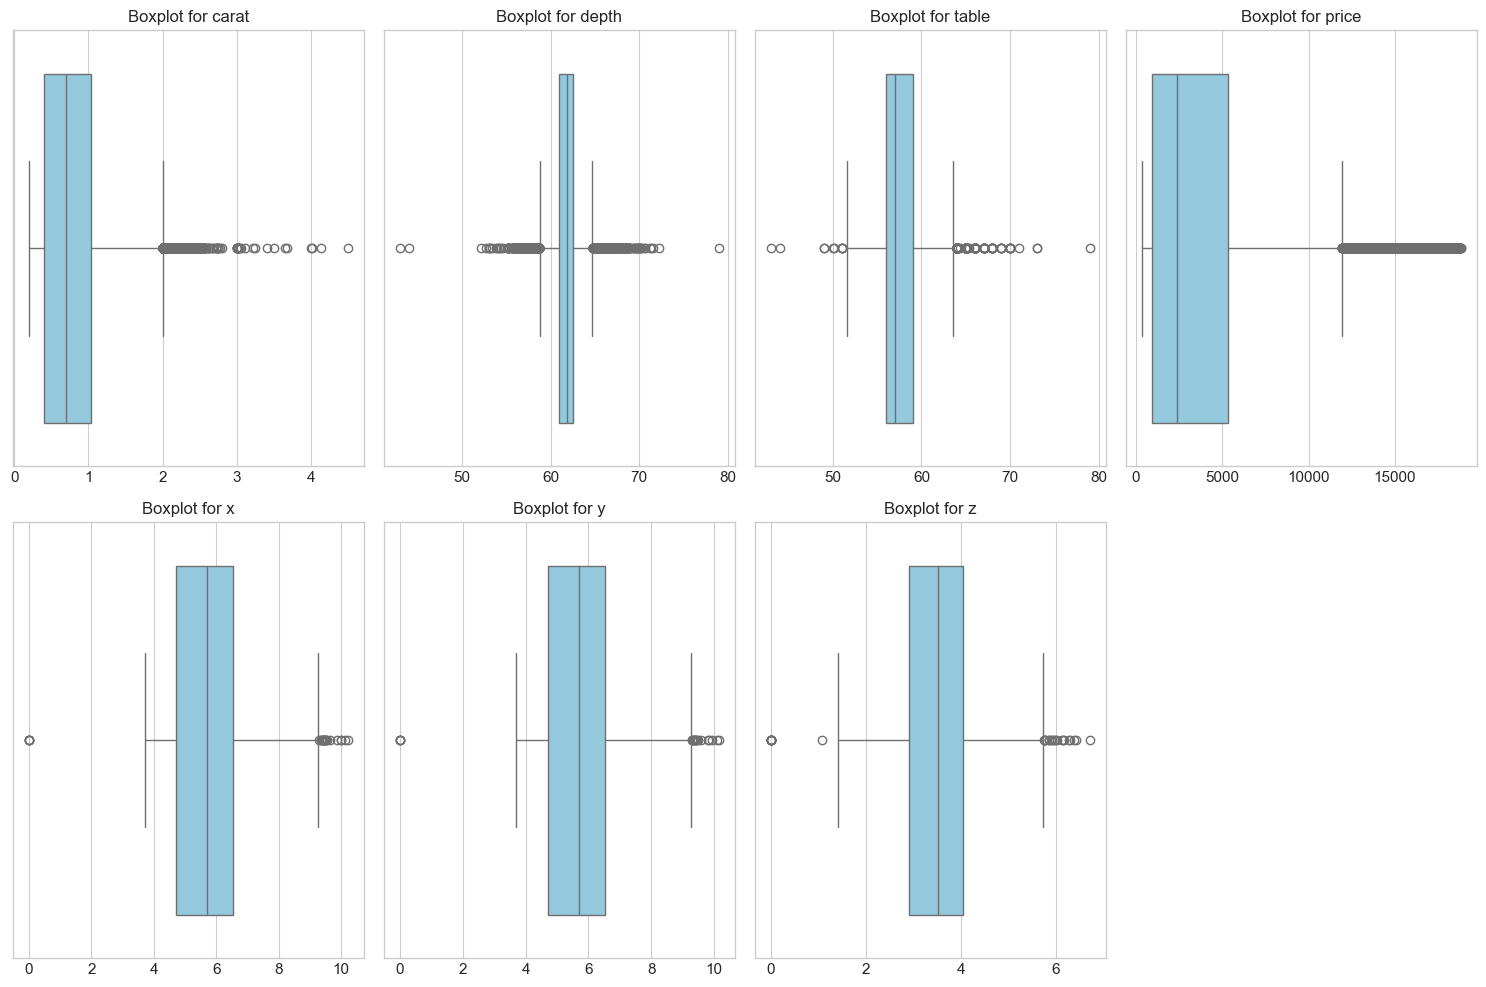

In [24]:
# Numerische Spalten auswählen
numeric_cols = df_train.select_dtypes(include=np.number).columns

# Dynamisch passende Grid-Größe bestimmen
n_cols = 4  # Anzahl der Boxplots pro Zeile
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

# Figure und Subplots erstellen
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Boxplots zeichnen
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df_train[col], ax=axes[i], color="skyblue")
    axes[i].set_title(f"Boxplot for {col}", fontsize=12)
    axes[i].set_xlabel("")

# Leere Subplots ausblenden
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Heatmap der Korrelationen:


<Axes: >

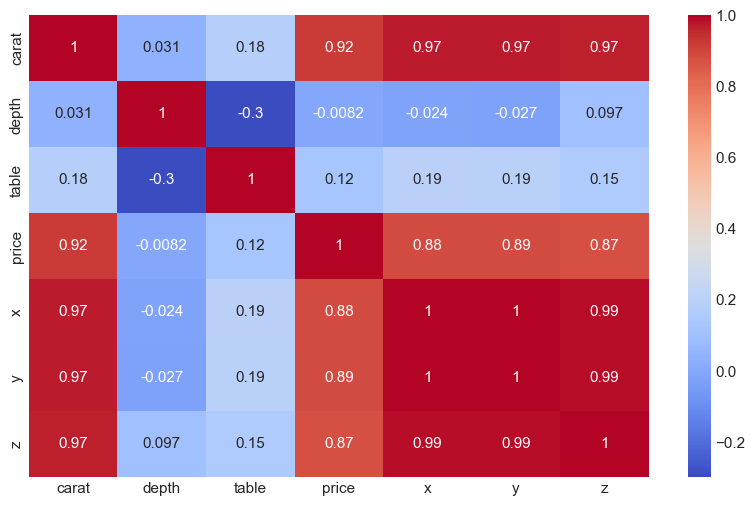

In [25]:
print("\nHeatmap der Korrelationen:")
print("="*50)

corr = df_train.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')

## Automatisches Reporting erstellen

In [26]:
print("\nMultikollinearität prüfen:")
print("="*50)

X = df_train.select_dtypes(include=np.number).drop(columns=['price'])
vif = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
vif


Multikollinearität prüfen:


,Feature,VIF
0,carat,72.105411
1,depth,660.101254
2,table,579.779784
3,x,8368.173243
4,y,7437.844106
5,z,1587.581234


## Explorative Data Analysis


EXPLORATORY DATA ANALYSIS


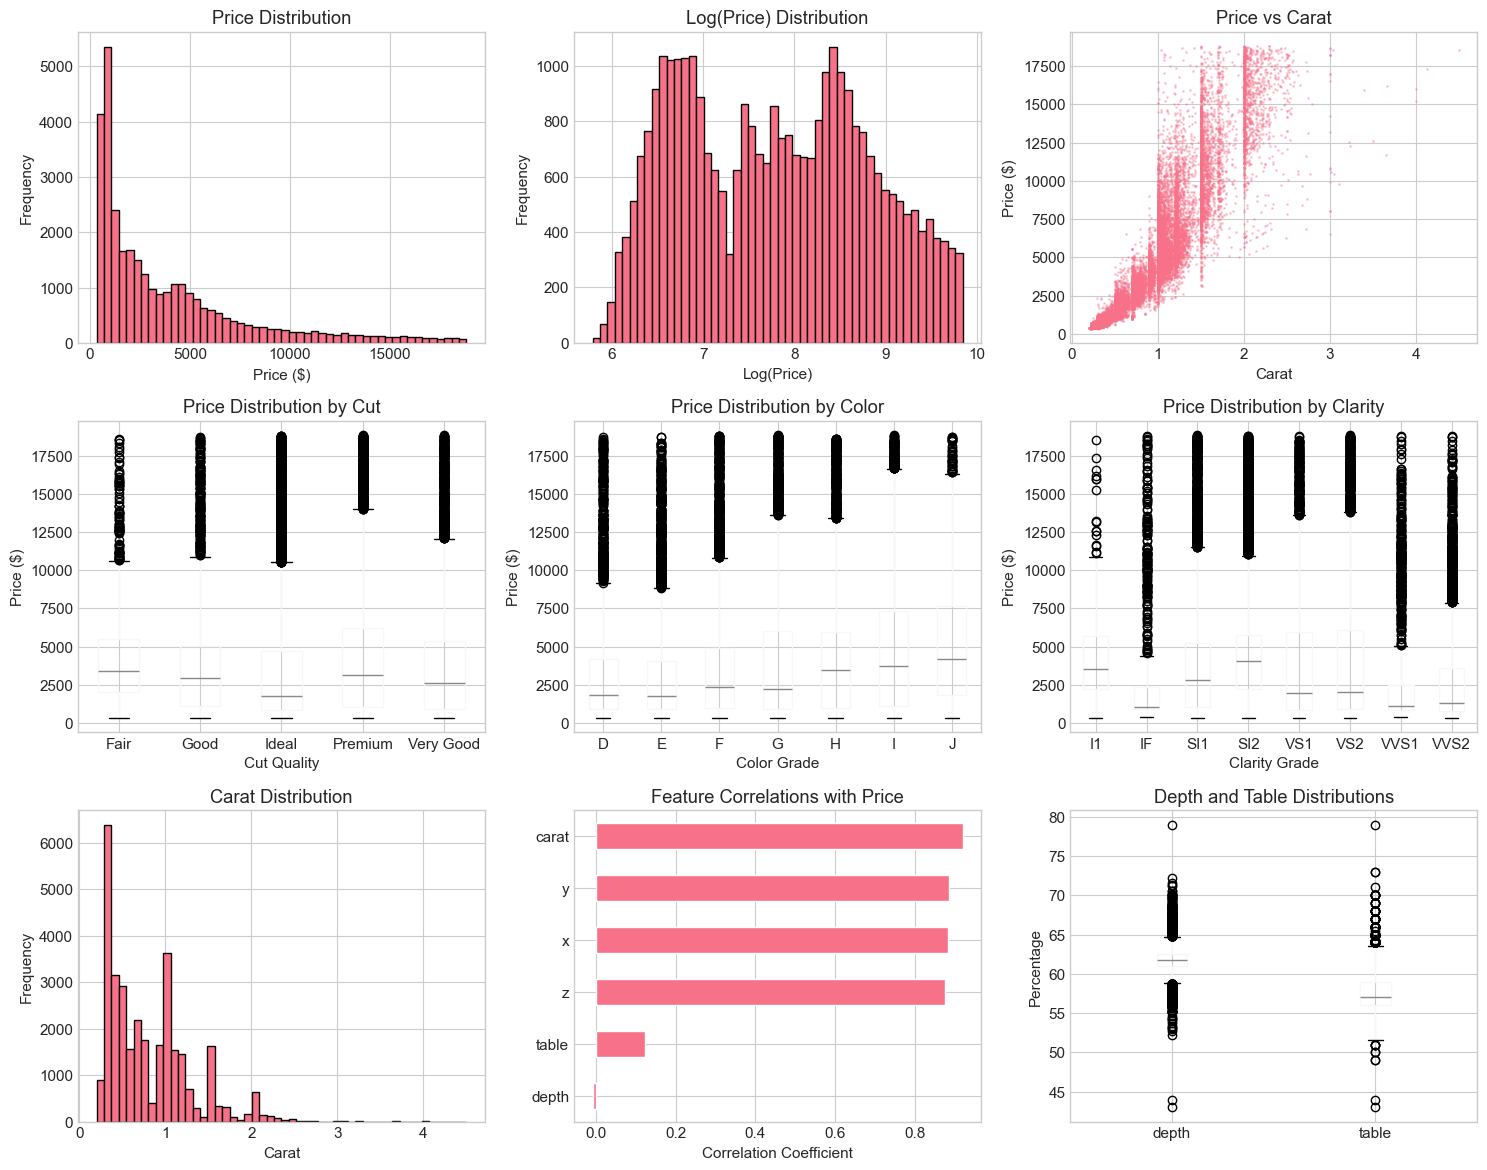

In [27]:
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Create figure for EDA plots
fig = plt.figure(figsize=(15, 12))

# 1. Price distribution
ax1 = plt.subplot(3, 3, 1)
df_train['price'].hist(bins=50, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

# 2. Log-transformed price distribution
ax2 = plt.subplot(3, 3, 2)
np.log1p(df_train['price']).hist(bins=50, edgecolor='black')
plt.title('Log(Price) Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

# 3. Price vs Carat
ax3 = plt.subplot(3, 3, 3)
plt.scatter(df_train['carat'], df_train['price'], alpha=0.3, s=1)
plt.title('Price vs Carat')
plt.xlabel('Carat')
plt.ylabel('Price ($)')

# 4. Price by Cut
ax4 = plt.subplot(3, 3, 4)
df_train.boxplot(column='price', by='cut', ax=ax4)
plt.title('Price Distribution by Cut')
plt.suptitle('')
plt.xlabel('Cut Quality')
plt.ylabel('Price ($)')

# 5. Price by Color
ax5 = plt.subplot(3, 3, 5)
df_train.boxplot(column='price', by='color', ax=ax5)
plt.title('Price Distribution by Color')
plt.suptitle('')
plt.xlabel('Color Grade')
plt.ylabel('Price ($)')

# 6. Price by Clarity
ax6 = plt.subplot(3, 3, 6)
df_train.boxplot(column='price', by='clarity', ax=ax6)
plt.title('Price Distribution by Clarity')
plt.suptitle('')
plt.xlabel('Clarity Grade')
plt.ylabel('Price ($)')

# 7. Carat distribution
ax7 = plt.subplot(3, 3, 7)
df_train['carat'].hist(bins=50, edgecolor='black')
plt.title('Carat Distribution')
plt.xlabel('Carat')
plt.ylabel('Frequency')

# 8. Correlation with price
ax8 = plt.subplot(3, 3, 8)
numeric_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
correlations = df_train[numeric_cols + ['price']].corr()['price'].drop('price').sort_values()
correlations.plot(kind='barh')
plt.title('Feature Correlations with Price')
plt.xlabel('Correlation Coefficient')

# 9. Feature distributions
ax9 = plt.subplot(3, 3, 9)
df_train[['depth', 'table']].boxplot(ax=ax9)
plt.title('Depth and Table Distributions')
plt.ylabel('Percentage')

plt.tight_layout()
plt.savefig('Save/eda_diamonds.png', dpi=300, bbox_inches='tight')
plt.show()